In [136]:
%pylab inline
import pandas as pd
import json
import seaborn as sns
import numpy as np

Populating the interactive namespace from numpy and matplotlib


/Users/melissagymrek/opt/miniconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f', 'sample']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [156]:
# load loci csv
loci = pd.read_csv('../data/csv/1000g_loci.csv')
# load prod size csv
prod_size = pd.read_csv('../data/csv/1000g_product_sizes.csv').set_index('PrimerID').drop(['Note', 'Unnamed: 0'], axis = 1)
prod_size.columns = prod_size.columns.str.replace(' ', '')
ref_prod_sizes = prod_size.query('SampleID == "Reference" or SampleID == "reference"').drop(['SampleID'], axis = 1)
samp_prod_sizes = prod_size.query('SampleID != "Reference" and SampleID !="reference"')

samp_prod_sizes[['prd_size_1','prd_size_2']] = samp_prod_sizes.Productsize.str.split('/',expand=True)[[0, 1]].astype(float).round(0)
samp_prod_sizes

/Users/melissagymrek/opt/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,SampleID,Productsize,Unnamed:5,Unnamed:6,Unnamed:7,prd_size_1,prd_size_2
PrimerID,,,,,,,
HOXD13,NA24385,503.92/503.92,NaN,NaN,NaN,504.0,504.0
HOXD13,NA24149,504.65/504.65,NaN,NaN,NaN,505.0,505.0
HOXD13,NA24143,504.43/504.43,NaN,NaN,NaN,504.0,504.0
HOXD13,NA24631,503.85/503.85,NaN,NaN,NaN,504.0,504.0
HOXD13,NA24694,503.81/503.81,NaN,NaN,NaN,504.0,504.0
...,...,...,...,...,...,...,...
chr9_6685998_TTA,NA24149,266.54/266.54,NaN,NaN,NaN,267.0,267.0
chr9_6685998_TTA,NA24385,266.54/266.54,NaN,NaN,NaN,267.0,267.0
chr9_6685998_TTA,NA24631,266.54/291.04,NaN,NaN,NaN,267.0,291.0


In [139]:
# load json for gangstr
with open('../data/json/gangstr_calls.json', 'r') as f:
    gangstr_calls = json.load(f)
# load json for hipstr
with open('../data/json/hipstr_calls.json', 'r') as f:
    hipstr_calls = json.load(f)


>> FXN offset=nan/nan nummatch=nan/nan


>> HOXD13 offset=nan/18 nummatch=nan/60


>> SCA2 offset=nan/nan nummatch=nan/nan


>> C9orf72 offset=8/8 nummatch=41/41


>> HTT offset=5/5 nummatch=37/18

************couldn't find motif for NOS1

>> ATXN10 offset=2/2 nummatch=54/54


>> DMPK offset=1/1 nummatch=43/43


>> JPH3 offset=nan/2 nummatch=nan/55


>> PHOX2B offset=nan/28 nummatch=nan/32


>> FOXL2 offset=nan/nan nummatch=nan/nan


>> CACNA1A offset=6/6 nummatch=40/40


>> ATN1 offset=nan/6 nummatch=nan/60


>> CNBP offset=nan/nan nummatch=nan/nan


>> SCA3 offset=nan/nan nummatch=nan/nan


>> PAPBN1 offset=nan/3 nummatch=nan/60


>> SCA1 offset=nan/nan nummatch=nan/nan


>> PPP2R2B offset=1/1 nummatch=41/41


>> AFF2 offset=nan/nan nummatch=nan/nan


>> ZIC2 offset=nan/2 nummatch=nan/58


>> SCA7 offset=nan/nan nummatch=nan/nan


>> AR offset=10/nan nummatch=53/nan



<ipython-input-157-342f0e6dcab6>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


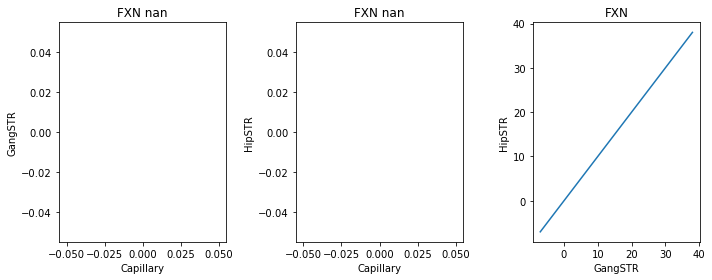

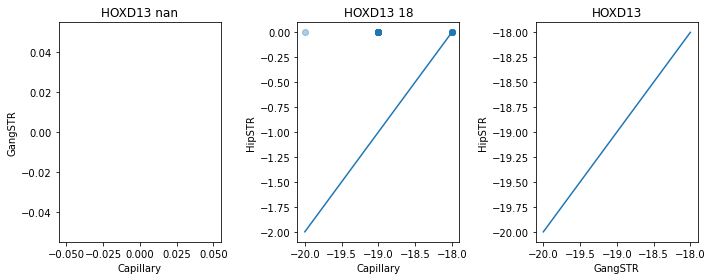

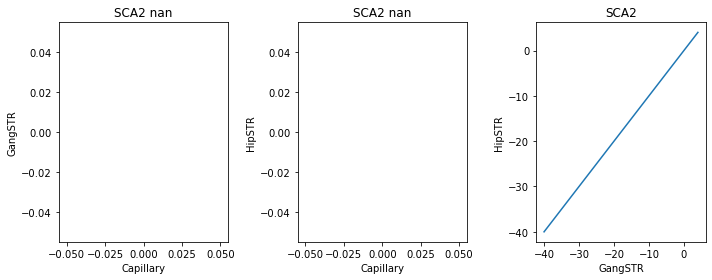

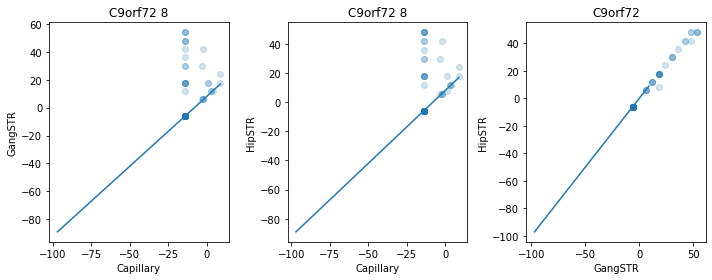

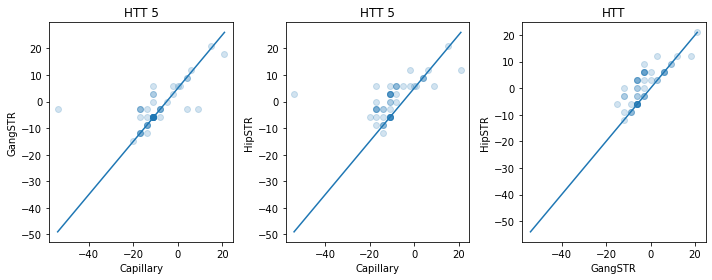

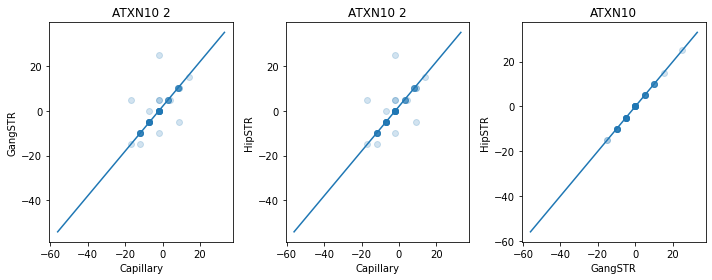

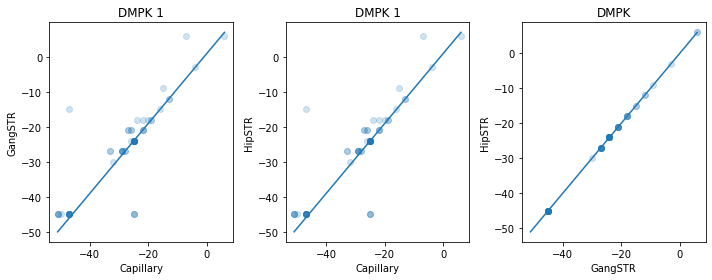

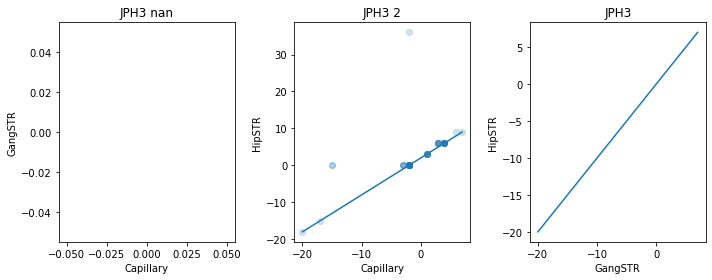

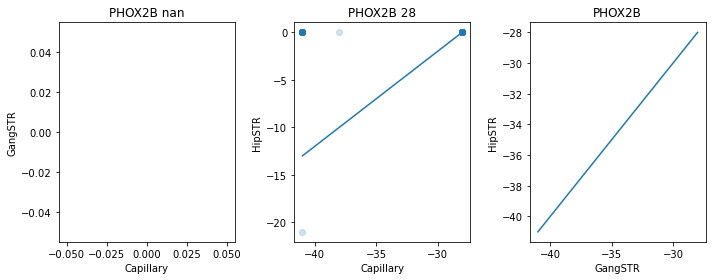

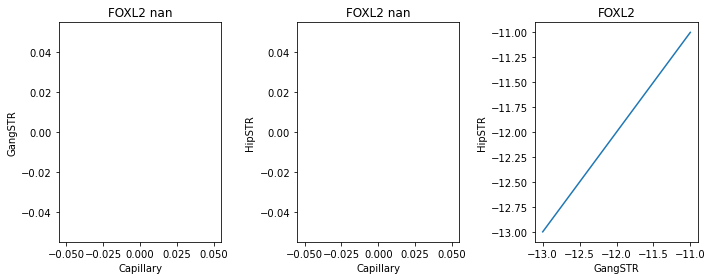

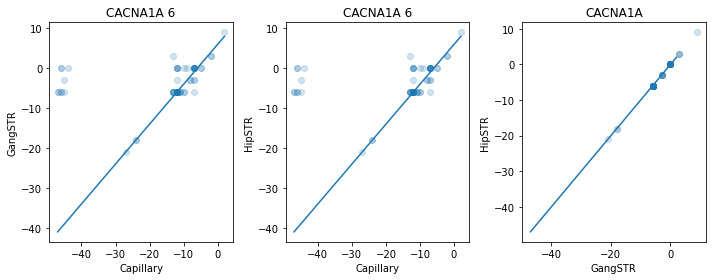

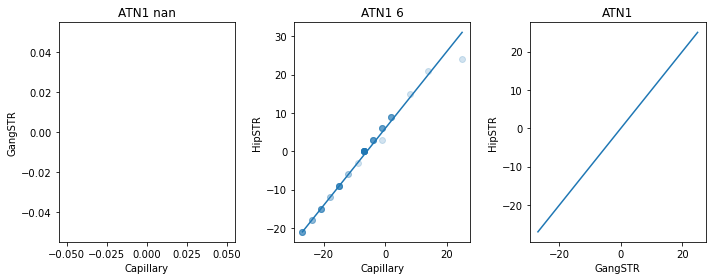

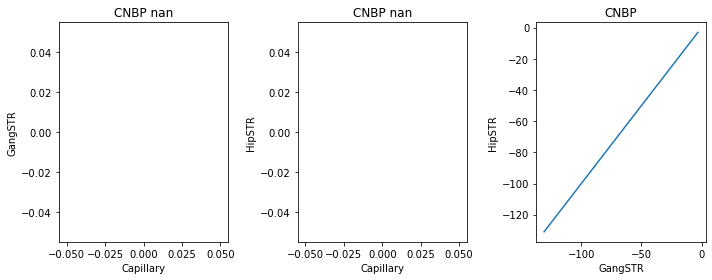

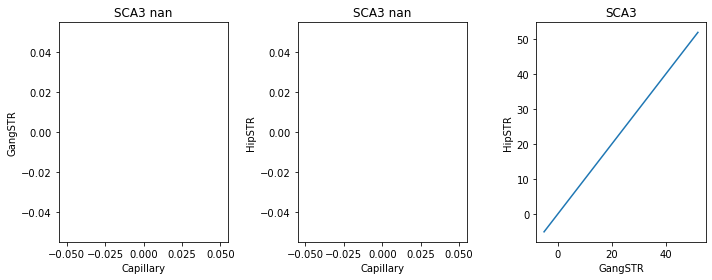

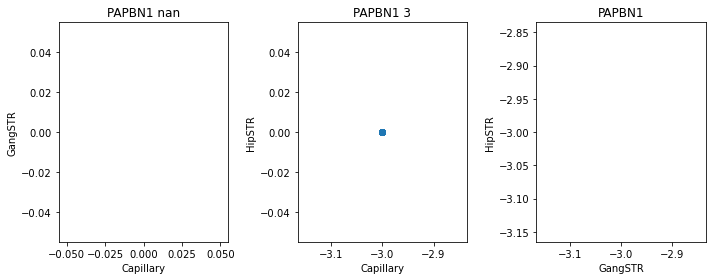

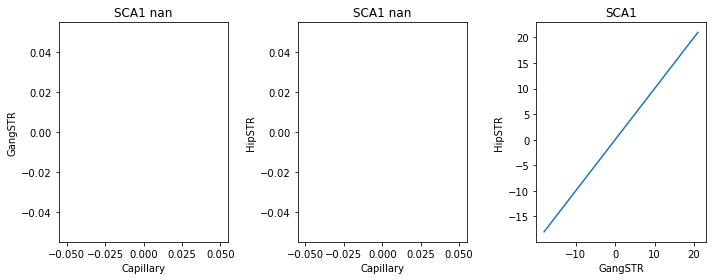

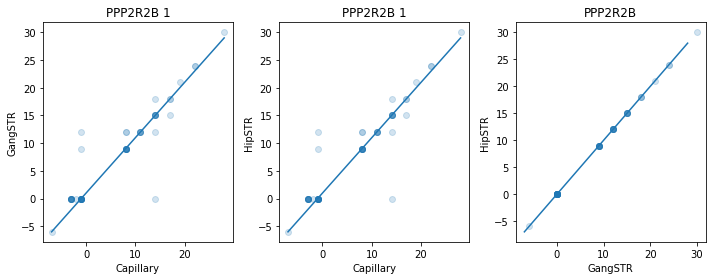

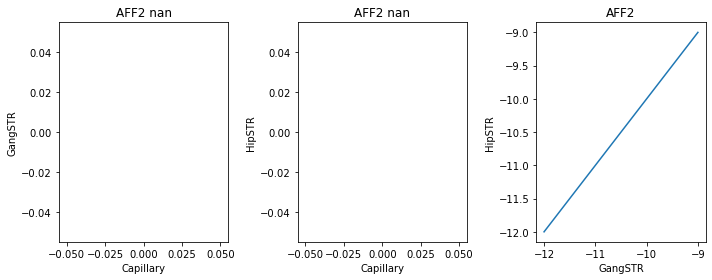

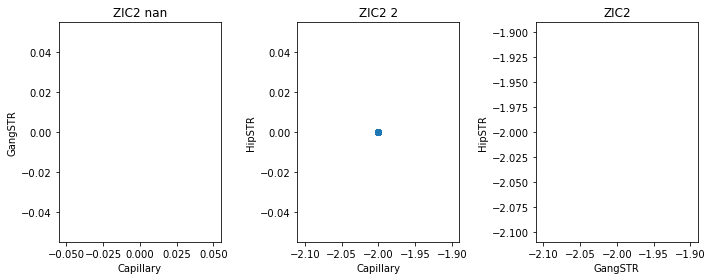

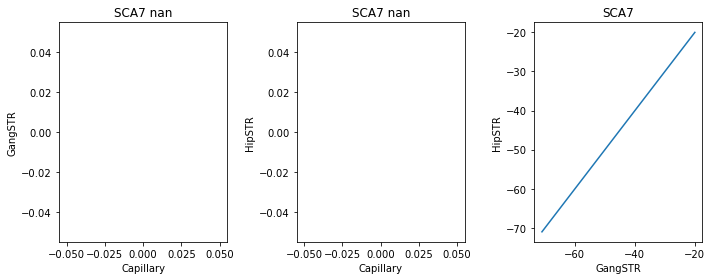

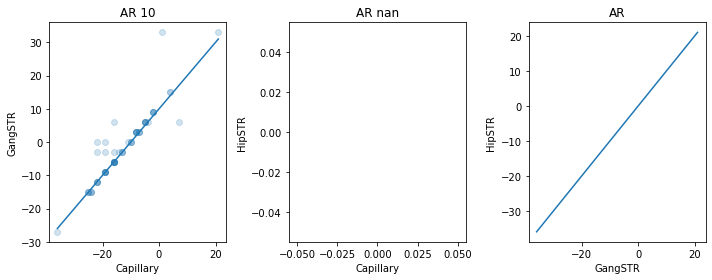

In [157]:
# Y = X + offset
def find_offset (X, Y, period):
    #print(X)
    #print(Y)
    newX = [X[i] for i in range(len(X)) if not np.isnan(Y[i])]
    newY = [item for item in Y if not np.isnan(item)]
    
    if len(newX) == 0: return np.nan, np.nan, np.nan
    # measure: diffs in sizes
    most_matches = -10
    best_diffs = 100000
    best_offset = -1000
    for offset in range(-30,30):
        x_plus_off = [x + offset for x in newX]
        
        # Get matches after round to nearest repeat unit
        rounded_x = [round(item/period) for item in x_plus_off]
        rounded_y = [round(item/period) for item in newY]
        num_matches = sum(np.equal(rounded_x, rounded_y))
        
        # Get diffs. Take top %percentile since we don't know how many calls are wrong
        diffs = [abs(x_plus_off[i]-newY[i]) for i in range(len(x_plus_off))]
        diff = np.max(sorted(diffs)[0:10]) #np.median(diffs)
        
        if diff < best_diffs:
            best_diffs = diff
            best_offset = offset
            most_matches = num_matches
    return best_offset, most_matches, best_diffs

for PrimerID in set(list(gangstr_calls.keys())+list(hipstr_calls.keys())):
    try:
        period = len(loci[loci["LocusID"]==PrimerID]["Motif"].values[0])
    except:
        print("************couldn't find motif for %s"%PrimerID)
        continue
    samp_loc_prod_sizes = samp_prod_sizes.query(f'PrimerID == "{PrimerID}"')
    X = [] # product size from capillary
    Y_gstr = [] # product size from gangstr
    Y_hstr = [] # product size from hipstr
    samples = [] # sample list
    
    for sample in list(samp_loc_prod_sizes["SampleID"]):
        # Extract capillary data
        cap_prod_sizes = list(samp_loc_prod_sizes.set_index('SampleID').loc[sample][['prd_size_1', 'prd_size_2']])
        ref_prod_size = list(ref_prod_sizes.loc[PrimerID])[0]
        if "prd_size_1" in cap_prod_sizes: continue
        gb_cap = sorted([float(i) - float(ref_prod_size) for i in cap_prod_sizes])
        if sum(np.isnan(gb_cap)) > 0: continue 
        X.extend(gb_cap)
        samples.extend([sample]*2)

        # Extract gangstr and hipstr data
        try:
            gb_gstr = sorted([float(i) for i in gangstr_calls[PrimerID][sample]['gb'].split(',')])
        except: gb_gstr = [np.nan, np.nan]
        if len(gb_gstr) == 1: gb_gstr = [gb_gstr[0]]*2 # for chrX ones
        Y_gstr.extend(gb_gstr)
            
        try:
            gb_hstr = sorted([float(i) for i in hipstr_calls[PrimerID][sample]['gb'].split(',')])
        except:
            gb_hstr = [np.nan, np.nan]
        Y_hstr.extend(gb_hstr)  
        

    offset_gstr, num_matches_gstr, diff_gstr = find_offset(X, Y_gstr, period)
    offset_hstr, num_matches_hstr, diff_hstr = find_offset(X, Y_hstr, period)

    print(f'\n>> {PrimerID} offset={offset_gstr}/{offset_hstr} nummatch={num_matches_gstr}/{num_matches_hstr}\n')

    xvals = [np.min(X), np.max(X)]
    fig = plt.figure()
    fig.set_size_inches((10, 4))
    ax = fig.add_subplot(131)
    ax.set_title(PrimerID + " %s"%offset_gstr)
    ax.set_xlabel("Capillary")
    ax.set_ylabel("GangSTR")
    ax.scatter(X, Y_gstr, alpha=0.2)
    Y_offset = [item+offset_gstr for item in xvals]
    ax.plot(xvals, Y_offset)
    
    ax = fig.add_subplot(132)
    ax.set_title(PrimerID + " %s"%offset_hstr)
    ax.set_xlabel("Capillary")
    ax.set_ylabel("HipSTR")
    ax.scatter(X, Y_hstr, alpha=0.2)
    Y_offset = [item+offset_hstr for item in xvals]
    ax.plot(xvals, Y_offset)
    
    ax = fig.add_subplot(133)
    ax.set_title(PrimerID)
    ax.set_xlabel("GangSTR")
    ax.set_ylabel("HipSTR")
    ax.scatter(Y_gstr, Y_hstr, alpha=0.2)
    Y_offset = xvals
    ax.plot(xvals, Y_offset)

    fig.tight_layout()